## Save

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install pip install volumentations-3D

In [ ]:
import sys

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import  ToTensor, Resize
from torch.utils.data import Subset

from tqdm import tqdm
from torchsummary import summary
import cv2
# from segment_anything import SamPredictor, sam_model_registry
# from segment_anything.utils.transforms import ResizeLongestSide
import nibabel as nib
import torch.nn.functional as F
from skimage import transform, io, segmentation

from volumentations import *


In [ ]:
img = np.load("/content/drive/MyDrive/voting_data_v2_v/input/BraTS-SSA-00002-000.npy")
lbl = np.load("/content/drive/MyDrive/voting_data_v2_v/mask/BraTS-SSA-00002-000.npy")

In [ ]:
def get_augmentation():
    return Compose([
        # Rotate((-15, 15), (0, 0), (0, 0), p=0.5),
        # Flip(0, p=1.0),
        Flip(1, p=0.5),
        Flip(2, p=0.5),
        RandomRotate90((1, 2), p=0.5),
        # RandomScale(scale_limit=[0.9, 1.1], interpolation=1, p=1.0),
        # RandomDropPlane(plane_drop_prob=0.1, axes=(0, 1, 2), p=0.4)

    ], p=0.7)


def apply_augmentation(img, lbl):
  augment = get_augmentation()


  data = {'image': img, 'mask': lbl}
  aug = augment(**data)

  img_aug, lbl_aug = aug['image'], aug['mask']

  return img_aug, lbl_aug


x, y = apply_augmentation(img, lbl)

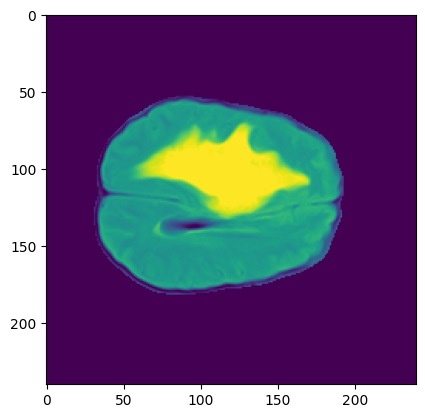

In [ ]:
plt.imshow(x[0,:,:,90])

## DATA

In [ ]:
!gcloud auth login

In [ ]:
!sudo zypper install gcc python3-devel
!sudo pip uninstall crcmod
!sudo pip install --no-cache-dir -U crcmod

In [ ]:
!mkdir BraTS_data_africa

In [ ]:
!gcloud config set project 	crafty-nova-394910
!gsutil -m cp -r gs://embedding_spark/BraTS_data_africa/t1/t1 ./BraTS_data_africa/
!gsutil -m cp -r gs://embedding_spark/BraTS_data_africa/t2 ./BraTS_data_africa/
!gsutil -m cp -r gs://embedding_spark/BraTS_data_africa/flair ./BraTS_data_africa/

# Prepare

In [ ]:
! pip install monai
! pip install pytorch-lightning
! pip install torchio

In [ ]:
from monai.networks.nets import UNet
from torchsummary import summary
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import Subset
from tqdm import tqdm
import monai
# from segment_anything import SamPredictor, sam_model_registry
# from segment_anything.utils.transforms import ResizeLongestSide
# import wandb
import nibabel as nib
# from segment_anything.utils.transforms import ResizeLongestSide
import torch.nn.functional as F
from skimage import transform, io, segmentation
import random
import pytorch_lightning as pl
import torchio as tio
from pytorch_lightning.callbacks import ModelCheckpoint



In [ ]:
input_path = "/content/drive/MyDrive/voting_data_v2_v"

def pixel_black_attack(mask, input_):
  idxs = np.where(mask[1]>0)
  # print(len(idxs))
  for i in range(3, input_.shape[0]):
    size = np.random.choice(30, 1)[0]/100

    # print(int(len(idxs[0])*size), size)

    selected_idxs_of_idxs = np.random.choice(len(idxs[0]), int(len(idxs[0])*size))

    selected_idxs = (idxs[0][selected_idxs_of_idxs],
                     idxs[1][selected_idxs_of_idxs],
                     idxs[2][selected_idxs_of_idxs])

    input_[i][selected_idxs]=0

  return input_


def plane_black_attack(mask, input_):
  idxs_z = np.where(mask[1]>0)[2]

  for i in range(3, input_.shape[0]):
    size = np.random.choice(10, 1)[0]/100

    # print(int(len(idxs[0])*size), size)

    selected_idxs_of_idxs = np.random.choice(len(idxs_z), int(len(idxs_z)*size))

    selected_idxs = idxs_z[selected_idxs_of_idxs]

    input_[i,:,:,selected_idxs]=0

  return input_


def case_black_attack(mask, input_):
  # idxs_z = np.where(mask[1]>0)
  idxs_z = np.array(list(range(mask.shape[-1]-1)))
  # print(idxs_z.shape, len(mask[1]>0), len((mask[1]>0)[-1]))
  size = np.random.choice(100, 1)[0]/100
  selected_idxs_of_idxs = np.random.choice(len(idxs_z), int(len(idxs_z)*size))
  selected_idxs = idxs_z[selected_idxs_of_idxs]


  # print(size, len(selected_idxs), input_.shape[-1])

  input_[:,:,:,selected_idxs]=0

  return input_

class BraTSDataset(Dataset):

    def __init__(self, ground_truth_path, device="cuda", isVal = True):
        """
        Args:
            embedding_path (string): Path to  images.
            masks_path (string): path to masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ground_truth_path = ground_truth_path
        self.device = device

        if isVal:
            self.data = os.listdir(self.ground_truth_path+"/input")[:38]
        else:
            self.data = os.listdir(self.ground_truth_path+"/input")[38:]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

      case_name = self.data[idx]

      input_orig = np.load(self.ground_truth_path+"/input/"+case_name)
      input_x = np.load(self.ground_truth_path+"/input_x"+case_name)
      input_y = np.load(self.ground_truth_path+"/input_y"+case_name)
      input_z = np.load(self.ground_truth_path+"/input_z"+case_name)


      input_ = np.stack((input_orig[:4,...], input_x, input_y, input_z), axis = 0)
      mask   = np.load(self.ground_truth_path+"/mask/"+case_name)


      # input_aug, mask_aug = apply_augmentation(input_, mask)

      # mask_aug[1][mask_aug[0,...]>0] = 1
      # mask_aug[1][mask_aug[2,...]>0] = 1

      # mask_aug[2][mask_aug[0,...]>0] = 1


      # input_aug = pixel_black_attack(mask_aug, input_aug)

      # input_aug = case_black_attack(mask_aug, input_aug)

      sample = {"input": input_,
                  'mask': mask,
                  }

      return sample

In [ ]:
ground_truth_path = "/content/voting_data_v2_v"

!cp -r /content/drive/MyDrive/voting_data_v2_v /content

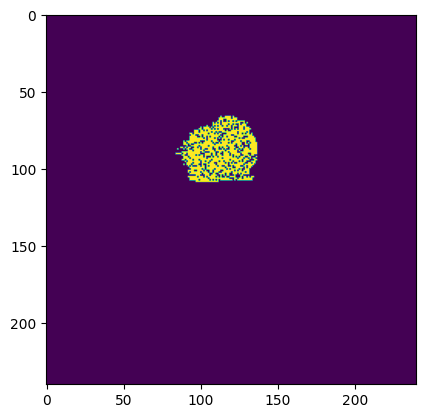

In [ ]:
ground_truth_path = "/content/voting_data_v2_v"

train = BraTSDataset(ground_truth_path)

for i in range(len(train)):
  inp = train[i]["input"]
  out = train[i]["mask"]
  # print(train[i])
  # plt.imshow(out[1,:,:,90])
  plt.imshow(inp[4,:,:,100])
  break

In [ ]:
# plt.imshow(inp[4,:,:,100])

# np.where(inp[4,:,:,:]>0)[2]


In [ ]:
train = BraTSDataset(ground_truth_path)
val = BraTSDataset(ground_truth_path, isVal = False)

device = "cuda"

print(len(train))
print(len(val))

# train_loader = DataLoader(train, batch_size= 8, shuffle=True, num_workers=2, prefetch_factor= 1)
# val_loader = DataLoader(val, batch_size= 8, shuffle=False, num_workers=2, prefetch_factor= 1)

train_loader = DataLoader(train, batch_size= 8, shuffle=True, num_workers=8, prefetch_factor= 1)
val_loader = DataLoader(val, batch_size= 4, shuffle=False, num_workers=8, prefetch_factor= 1)


hprams = {
    "num_epochs": 200,
    "best_loss": 1e10,
    "model_save_path": "/content/drive/MyDrive/miccai_data",
    "lr":1e-2,
    "weight_decay":0,
    "device": device,
    "train_dataloader": train_loader,
    "val_dataloader": val_loader
    }

40
3


In [ ]:
# must have augmentation
# net = UNet(
#     spatial_dims=3,
#     in_channels=7,
#     out_channels=3,
#     channels=(16, 32, 64, 128, 256),
#     strides=(2, 2, 2, 2),
# ).to(device)

net = UNet(
    spatial_dims=3,
    in_channels=16,
    out_channels=3,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 3),
    # num_res_units=5
).to(device)


# net = UNet(
#     spatial_dims=3,
#     in_channels=8,
#     out_channels=3,
#     channels=(64, 128, 256),
#     strides=(2, 2),
#     # num_res_units=5
# ).to(device)

In [ ]:
a,b = np.zeros((7, 240, 240, 155)), np.zeros((7, 240, 240, 5))
np.concatenate((a,b), axis=-1).shape

(7, 240, 240, 160)

In [ ]:
summary(net, (8, 240, 240, 155))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 120, 120, 78]          13,888
    InstanceNorm3d-2     [-1, 64, 120, 120, 78]               0
           Dropout-3     [-1, 64, 120, 120, 78]               0
             PReLU-4     [-1, 64, 120, 120, 78]               1
            Conv3d-5      [-1, 128, 60, 60, 39]         221,312
    InstanceNorm3d-6      [-1, 128, 60, 60, 39]               0
           Dropout-7      [-1, 128, 60, 60, 39]               0
             PReLU-8      [-1, 128, 60, 60, 39]               1
            Conv3d-9      [-1, 256, 20, 20, 13]         884,992
   InstanceNorm3d-10      [-1, 256, 20, 20, 13]               0
          Dropout-11      [-1, 256, 20, 20, 13]               0
            PReLU-12      [-1, 256, 20, 20, 13]               1
           Conv3d-13      [-1, 512, 20, 20, 13]       3,539,456
   InstanceNorm3d-14      [-1, 512, 20,

In [ ]:
s = np.zeros((1,8, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
net(s).shape

torch.Size([1, 3, 240, 240, 156])

In [ ]:
loss_function = monai.losses.GeneralizedDiceFocalLoss(sigmoid=True, softmax=False, to_onehot_y = False).to(device)
optimizer = torch.optim.Adam(net.parameters(), hprams["lr"])



In [ ]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def forward(self, input_):
      return self.net(input_)

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, verbose=True)
        # return [optimizer], [scheduler]
        return {"optimizer": optimizer,
                "lr_scheduler": scheduler,
                "monitor": "val_loss"}

    def prepare_batch(self, batch):
        return (batch["input"], batch["mask"])



    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        return loss

In [ ]:
model = Model(
    net=net,
    criterion=loss_function,
    learning_rate=hprams["lr"],
    optimizer_class=torch.optim.Adam,
)
early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor="val_loss", patience=40)


checkpoint_callback = ModelCheckpoint(
    dirpath = hprams["model_save_path"],
    filename = "voting_unet_small",
    save_last = True,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
)

trainer = pl.Trainer(
    default_root_dir= hprams["model_save_path"],
    callbacks=[early_stopping, checkpoint_callback],
    log_every_n_steps=3,
    max_epochs = hprams["num_epochs"],
    # accelerator="gpu", devices=2, num_nodes=2, strategy="ddp"
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                     | Params
-------------------------------------------------------
0 | net       | UNet                     | 7

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 5: 'val_loss' reached 0.73582 (best 0.73582), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 10: 'val_loss' reached 0.45823 (best 0.45823), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 15: 'val_loss' reached 0.34979 (best 0.34979), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 20: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 25: 'val_loss' reached 0.32482 (best 0.32482), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 30: 'val_loss' reached 0.31670 (best 0.31670), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 35: 'val_loss' reached 0.30096 (best 0.30096), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 40: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 45: 'val_loss' reached 0.29664 (best 0.29664), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 50: 'val_loss' reached 0.28719 (best 0.28719), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 55: 'val_loss' reached 0.28412 (best 0.28412), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 60: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 65: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 70: 'val_loss' reached 0.25277 (best 0.25277), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 75: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 80: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 85: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 90: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 95: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 105: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 110: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 115: 'val_loss' reached 0.24113 (best 0.24113), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 120: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 125: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 130: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 135: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 140: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 145: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 150: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 155: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 160: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 165: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 170: 'val_loss' reached 0.23790 (best 0.23790), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 175: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 180: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 185: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 190: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 195: 'val_loss' reached 0.23179 (best 0.23179), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 205: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 210: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 215: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 220: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 225: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 230: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 235: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 240: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 245: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 250: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 50, global step 255: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 51, global step 260: 'val_loss' reached 0.22433 (best 0.22433), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 52, global step 265: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 53, global step 270: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 54, global step 275: 'val_loss' reached 0.22225 (best 0.22225), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 55, global step 280: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 56, global step 285: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 57, global step 290: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 58, global step 295: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 59, global step 300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 60, global step 305: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 61, global step 310: 'val_loss' reached 0.21820 (best 0.21820), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 62, global step 315: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 63, global step 320: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 64, global step 325: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 65, global step 330: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 66, global step 335: 'val_loss' reached 0.21169 (best 0.21169), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 67, global step 340: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 68, global step 345: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 69, global step 350: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 70, global step 355: 'val_loss' reached 0.20613 (best 0.20613), saving model to '/content/drive/.shortcut-targets-by-id/1SI0RhxpAQ-odXl-H3SGYTraKQZvjInxq/miccai_data/voting_unet_small-v25.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 71, global step 360: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 72, global step 365: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 73, global step 370: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 74, global step 375: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 75, global step 380: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 76, global step 385: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 77, global step 390: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 78, global step 395: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 79, global step 400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 80, global step 405: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 81, global step 410: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 82, global step 415: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 83, global step 420: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 84, global step 425: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 85, global step 430: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 86, global step 435: 'val_loss' was not in top 1


Epoch 00087: reducing learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 87, global step 440: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 88, global step 445: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 89, global step 450: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 90, global step 455: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 91, global step 460: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 92, global step 465: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 93, global step 470: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 94, global step 475: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 95, global step 480: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 96, global step 485: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 97, global step 490: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 98, global step 495: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 99, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 100, global step 505: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 101, global step 510: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 102, global step 515: 'val_loss' was not in top 1


Epoch 00103: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 103, global step 520: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 104, global step 525: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 105, global step 530: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 106, global step 535: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 107, global step 540: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 108, global step 545: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 109, global step 550: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 110, global step 555: 'val_loss' was not in top 1


# eval

In [ ]:
# model2 = torch.load(hprams["model_save_path"]+"/voting_unet_small-v4.ckpt")

PATH = hprams["model_save_path"]+"/voting_unet_small-v25.ckpt"
model2 = Model.load_from_checkpoint(PATH,
                                   net=net,
                                   criterion=loss_function,
                                   learning_rate=hprams["lr"],
                                   optimizer_class=torch.optim.Adam
                                   )


[7.5602029e-33 1.2012698e-32 3.0692351e-32 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0. 1. 2. 3.]
1.0 0.0 0.0015978942 float32


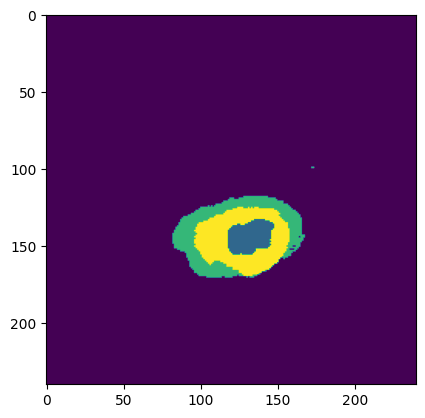

In [ ]:
s = np.load("/content/voting_data_v2_v/input/BraTS-SSA-00122-000.npy")
s = np.expand_dims(s, axis = 0)
s = torch.as_tensor(s, dtype=torch.float ).to(device)

model2 = model2.to("cuda")
out = model2.net(s)


m = out

m =torch.sigmoid(m).cpu().detach().numpy()

# lower_bound, upper_bound = np.percentile(m, 0.5), np.percentile(m, 99.5)
# image_data_pre = np.clip(m, lower_bound, upper_bound)
# d = (np.max(image_data_pre)-np.min(image_data_pre))
# d = 1 if d==0 else d
# image_data_pre = ((image_data_pre - np.min(image_data_pre))/d)
# image_data_pre[m==0] = 0
# m = image_data_pre
# thr=0.1
# m[m>=thr]= 1
# m[m<thr] = 0
# m = 1-m
m = np.squeeze(m, axis = 0)
# m = np.int32(m)
print(np.unique(m))
m = m[:,:,:,:155]

output = np.zeros(m.shape[1:], np.float32)

msk1 = m[0]
msk1[msk1<0.5]= 0
msk1[msk1>=0.5]= 1

msk2 = m[1]
msk2[msk2>=0.5]= 1
msk2[msk2<0.5]= 0

msk3 = m[2]
msk3[msk3>=0.5]= 1
msk3[msk3<0.5]= 0


output[msk2>0] = 2
output[msk3>0] = 3
output[msk1>0] = 1
print(np.unique(output))

print(msk1.max(), msk1.min(), msk1.mean(), output.dtype)


plt.imshow(output[:,:,110])

[0. 1.]


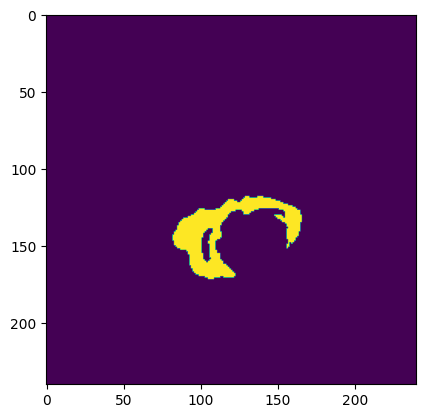

In [ ]:
l = np.load("/content/voting_data_v2_v/mask/BraTS-SSA-00122-000.npy")

print(np.unique(l[2]))

plt.imshow(l[1,:,:,110])

In [ ]:
s = np.zeros((1,7, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
model2 = model2.to("cuda")
print(model2.net(s).shape)

model2.freeze()

with torch.no_grad():
    y_hat = model2(s)

print(y_hat.shape)

((model2.net(s).cpu().numpy()-y_hat.cpu().numpy())).sum()

torch.Size([1, 3, 240, 240, 156])
torch.Size([1, 3, 240, 240, 156])


-0.43266147

In [ ]:
!ls '/content/drive/MyDrive/miccai_data/'

BraTS_Africa_data.zip  last-v3.ckpt		  voting_unet_small-v2.ckpt
BraTS_data_africa      last-v4.ckpt		  voting_unet_small-v3.ckpt
last.ckpt	       lightning_logs		  voting_unet_small-v4.ckpt
last-v1.ckpt	       voting_unet_small.ckpt
last-v2.ckpt	       voting_unet_small-v1.ckpt


In [ ]:
# lst[-60:-30]

In [ ]:
trainer.save_checkpoint("example.ckpt")

In [ ]:
torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/save_to/voting/model_best.pt")

In [ ]:
checkpoint = torch.load("/content/model.pt")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
checkpoint = torch.load('/content/voting_model_best.pt')
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/voting_model_best.pt")

In [ ]:
s = np.zeros((1,7, 240, 240, 155), dtype= np.float32)
s = torch.from_numpy(s).to("cuda")
model.forward(s)

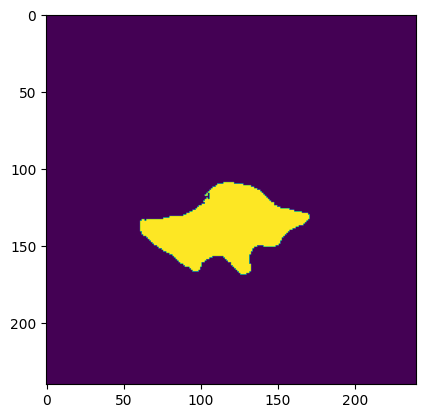

In [2]:
import numpy as np
import matplotlib.pyplot as plt


img = np.load("/content/drive/MyDrive/voting_data_v2_v/input/BraTS-SSA-00002-000.npy")
plt.imshow(img[6, :,:, 90])

# 3 ch to 1 ch

In [ ]:
def tranform_mask(mask):
  res = np.zeros(mask.shape[1:])

  msk1 = mask[0]
  msk2 = mask[1]
  msk3 = mask[2]

  res[msk1>0] = 1
  res[msk2>0] = 2
  res[msk3>0] = 3

  return res


